In [174]:
import pandas as pd
import numpy as np
import vertica_python
import os
import seaborn as sns

In [175]:
%matplotlib inline
sns.set_style("darkgrid")
sns.set_context("poster", font_scale=1, rc={"lines.linewidth": 2})

In [176]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [177]:
query = """

SELECT
    *,
    CASE 
    WHEN ms_course_program_number::int < 5 THEN 'Unit 1'
    WHEN ms_course_program_number::int < 8 THEN 'Unit 2'
    WHEN ms_course_program_number::int < 11 THEN 'Unit 3'
    ELSE NULL
    END AS ms_course_program_group
FROM
(
SELECT
    a.course_number,
    a.course_id AS lower_course_id,
    b.course_id AS higher_course_id,
    e.program_type,
    e.program_title,
    CASE
        WHEN a.course_seat_price BETWEEN 20 AND 35 AND b.course_seat_price BETWEEN 45 AND 55 THEN '25 to 50'
        WHEN a.course_seat_price BETWEEN 45 AND 55 AND b.course_seat_price BETWEEN 95 AND 105 THEN '49 to 99'
        ELSE 'other'
    END AS price_increase_grouping,
    	CASE
		WHEN a.course_subject IN
		(
			'Biology & Life Sciences',
			'Chemistry',
			'Computer Science',
			'Data Analysis & Statistics',
			'Electronics',
			'Energy & Earth Sciences',
			'Engineering',
			'Math',
			'Physics',
			'Science'
		) THEN 'STEM'
		ELSE 'non-STEM'
	END AS stem_non_stem,
    CASE
        WHEN b.course_id = 'course-v1:Microsoft+DAT101x+2T2017' AND a.course_id = 'course-v1:Microsoft+DAT101x+1T2017' THEN  '1'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT201x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT201x+1T2017' THEN  '2'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT206x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT206x+1T2017' THEN  '3'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT207x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT207x+1T2017' THEN  '3'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT222x+2T2017' AND a.course_id = 'course-v1:Microsoft+DAT222x+1T2017'  THEN  '4'
        WHEN b.course_id = 'course-v1:Microsoft+DAT204x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT204x+1T2017' THEN  '5'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT208x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT208x+1T2017' THEN  '5'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT203.1x+2T2017' AND a.course_id = 'course-v1:Microsoft+DAT203.1x+1T2017'   THEN  '6' 
        WHEN b.course_id = 'course-v1:Microsoft+DAT203.2x+2T2017' AND a.course_id = 'course-v1:Microsoft+DAT203.2x+1T2017'   THEN  '7' 
        WHEN b.course_id = 'course-v1:Microsoft+DAT209x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT209x+1T2017' THEN  '8'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT210x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT210x+1T2017' THEN  '8'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT203.3x+2T2017' AND a.course_id = 'course-v1:Microsoft+DAT203.3x+1T2017'   THEN  '9' 
        WHEN b.course_id = 'course-v1:Microsoft+DAT211x+2T2017' AND a.course_id =  'course-v1:Microsoft+DAT211x+1T2017' THEN  '9'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT202.3x+2T2017' AND a.course_id ='course-v1:Microsoft+DAT202.3x+1T2017'   THEN  '9' 
        WHEN b.course_id = 'course-v1:Microsoft+DAT213x+3T2017' AND a.course_id =  'course-v1:Microsoft+DAT213x+3T2017' THEN  '9'   
        WHEN b.course_id = 'course-v1:Microsoft+DAT102x+1T2017' AND a.course_id =  'course-v1:Microsoft+DAT102x+1T2017' THEN  '10'  
        WHEN b.course_id = 'course-v1:Microsoft+DAT102x+2T2017'  AND a.course_id = 'course-v1:Microsoft+DAT102x+1T2017' THEN '10'
        ELSE NULL
        END AS ms_course_program_number,
    e.program_slot_number::varchar,
    a.pacing_type,
    a.course_partner,
    a.course_subject,
    a.level_type,
    a.course_verification_end_date AS lower_course_verification_end_date, 
    b.course_verification_end_date AS higher_course_verification_end_date,
    a.course_seat_price AS lower_course_price,
    b.course_seat_price AS higher_course_price,
    (b.course_seat_price - a.course_seat_price) AS price_difference,
    c.sum_enrolls_vtr AS lower_course_enrolls,
    c.sum_verifications AS lower_course_verifications,
    c.sum_bookings AS lower_course_bookings,
    c.vtr * 100.0 AS lower_course_vtr,
    d.sum_enrolls_vtr AS higher_course_enrolls,
    d.sum_verifications AS higher_course_verifications,
    (d.sum_verifications - f.cnt_discounted_verifications) AS higher_course_verifications_minus_vouchers,
    d.sum_bookings AS higher_course_bookings,
    d.vtr * 100.0 AS higher_course_vtr,
    ((d.sum_verifications - COALESCE(f.cnt_discounted_verifications, 0))*100.0/(d.sum_enrolls_vtr - COALESCE(f.cnt_discounted_verifications, 0))) AS undiscounted_vtr,
    (b.course_seat_price - a.course_seat_price) * 100.0/(a.course_seat_price) AS pct_difference_price,
    (d.vtr - c.vtr)*100.0/(c.vtr) AS pct_difference_vtr,
    (((d.sum_verifications - COALESCE(f.cnt_discounted_verifications, 0))/(d.sum_enrolls_vtr - COALESCE(f.cnt_discounted_verifications, 0))) - c.vtr)*100.0/(c.vtr) AS pct_difference_undiscounted_vtr,
    ((d.vtr - c.vtr)/(c.vtr)) / ((b.course_seat_price - a.course_seat_price)/(a.course_seat_price)) AS price_elasticity,
    c.vtr * a.course_seat_price AS expected_value_lower,
    d.vtr * b.course_seat_price AS expected_value_higher,
    d.vtr * g.avg_transaction_amount AS expected_value_higher_actual_price,
    ((d.sum_verifications - COALESCE(f.cnt_discounted_verifications, 0))/(d.sum_enrolls_vtr - COALESCE(f.cnt_discounted_verifications, 0))) * b.course_seat_price AS expected_value_higher_undiscounted,
    ((d.vtr * b.course_seat_price) - (c.vtr * a.course_seat_price)) *100.0 / (c.vtr * a.course_seat_price) AS pct_difference_expected_value,
    ((d.vtr * g.avg_transaction_amount) - (c.vtr * a.course_seat_price)) *100.0 / (c.vtr * a.course_seat_price) AS pct_difference_expected_value_actual_price,
    ((((d.sum_verifications - COALESCE(f.cnt_discounted_verifications, 0))/(d.sum_enrolls_vtr - COALESCE(f.cnt_discounted_verifications, 0))) * b.course_seat_price) - (c.vtr * a.course_seat_price)) *100.0 / (c.vtr * a.course_seat_price) AS pct_difference_expected_value_undiscounted,
    CASE WHEN (b.course_seat_price)/(a.course_seat_price) * (d.vtr)/(c.vtr) < 1 THEN 1 ELSE 0 END AS is_worse,
    CASE 
        WHEN a.course_verification_end_date > b.course_verification_end_date THEN YEAR(a.course_verification_end_date)
        ELSE YEAR(b.course_verification_end_date)
    END AS year
FROM
    business_intelligence.course_master a
JOIN
    business_intelligence.course_master b
ON
    a.course_number = b.course_number
AND
    a.course_id != b.course_id
AND
    a.course_verification_end_date <= CURRENT_DATE()
AND
    b.course_verification_end_date <= CURRENT_DATE()
AND
    a.is_wl = 0
AND
    ABS(DATEDIFF('day', a.course_verification_end_date, b.course_verification_end_date)) < 364
AND
    (b.course_seat_price - a.course_seat_price) >= 5
AND
    a.pacing_type = b.pacing_type
AND
    a.level_type = b.level_type
JOIN
    business_intelligence.course_stats_summary c
ON
    a.course_id = c.course_id
AND
    c.sum_enrolls > 200
JOIN
    business_intelligence.course_stats_summary d
ON
    b.course_id = d.course_id
AND
    d.sum_enrolls > 200
LEFT JOIN
    production.d_program_course e
ON
    a.course_id = e.course_id
LEFT JOIN
(
    SELECT
        course_id,
        COUNT(1) as cnt_discounted_verifications
    FROM 
        business_intelligence.voucher_redemption
    WHERE 
        voucher_code = 'MPP50'
    GROUP BY 
        course_id
) f
ON
    b.course_id = f.course_id
LEFT JOIN
(
    select order_course_id AS course_id, avg(transaction_amount) AS avg_transaction_amount
    from finance.f_orderitem_transactions
    where order_course_id IN
    (
    'course-v1:Microsoft+DAT202.3x+2T2017',
    'course-v1:Microsoft+DAT203.3x+2T2017',
    'course-v1:Microsoft+DAT211x+2T2017',
    'course-v1:Microsoft+DAT209x+2T2017',
    'course-v1:Microsoft+DAT210x+2T2017',
    'course-v1:Microsoft+DAT203.2x+2T2017',
    'course-v1:Microsoft+DAT203.1x+2T2017',
    'course-v1:Microsoft+DAT204x+2T2017',
    'course-v1:Microsoft+DAT208x+2T2017',
    'course-v1:Microsoft+DAT206x+2T2017',
    'course-v1:Microsoft+DAT207x+2T2017',
    'course-v1:Microsoft+DAT201x+2T2017',
    'course-v1:Microsoft+DAT101x+2T2017'

    ) 
    and transaction_date is not null
    and transaction_type = 'sale'
    and order_product_class = 'seat'
    and order_voucher_code IN ('', 'MPP50')
    group by 1
) g
ON
    b.course_id = g.course_id
) a
"""

In [178]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(query)
extract = cur.fetchall()
df = pd.DataFrame(extract)

connection.close()

In [179]:
df.head()

,course_number,lower_course_id,higher_course_id,program_type,program_title,price_increase_grouping,stem_non_stem,ms_course_program_number,program_slot_number,pacing_type,...,expected_value_lower,expected_value_higher,expected_value_higher_actual_price,expected_value_higher_undiscounted,pct_difference_expected_value,pct_difference_expected_value_actual_price,pct_difference_expected_value_undiscounted,is_worse,year,ms_course_program_group
0,GeorgetownX+PHYX152x,course-v1:GeorgetownX+PHYX152x+2016_T1,GeorgetownX/PHYX152x/1T2015,None,None,49 to 99,STEM,None,None,instructor_paced,...,0.391738,0.017409,NaN,0.017409,-95.555837,NaN,-95.555837,1,2016,None
1,McGillX+Body101x,course-v1:McGillX+Body101x+1T2016,McGillX/Body101x/1T2015,None,None,49 to 99,non-STEM,None,None,instructor_paced,...,0.391806,0.295262,NaN,0.295262,-24.640810,NaN,-24.640810,1,2016,None
2,BUx+Math226.2x,course-v1:BUx+Math226.2x+2T2015,course-v1:BUx+Math226.2x+1T2016,None,None,25 to 50,STEM,None,None,instructor_paced,...,0.342298,0.605873,NaN,0.605873,77.001546,NaN,77.001546,0,2016,None
3,BUx+PY1x,BUx/PY1x/1T2015,course-v1:BUx+PY1x+3T2015,None,None,25 to 50,STEM,None,None,instructor_paced,...,0.187822,0.188800,NaN,0.188800,0.520851,NaN,0.520851,0,2016,None
4,BerkeleyX+CS169.1x,course-v1:BerkeleyX+CS169.1x+3T2015,course-v1:BerkeleyX+CS169.1x+3T2015SP,Professional Certificate,Agile Development Using Ruby on Rails,49 to 99,STEM,None,1,instructor_paced,...,0.762278,0.779889,NaN,0.779889,2.310340,NaN,2.310340,0,2016,None


In [180]:
#df['vtr'] = df.vtr.astype(float)
df['pct_difference_vtr'] = df.pct_difference_vtr.astype(float)
df['pct_difference_undiscounted_vtr'] = df.pct_difference_undiscounted_vtr.astype(float)

## Price Elasticity

### % change in VTR / % change in $$

#### Microsoft

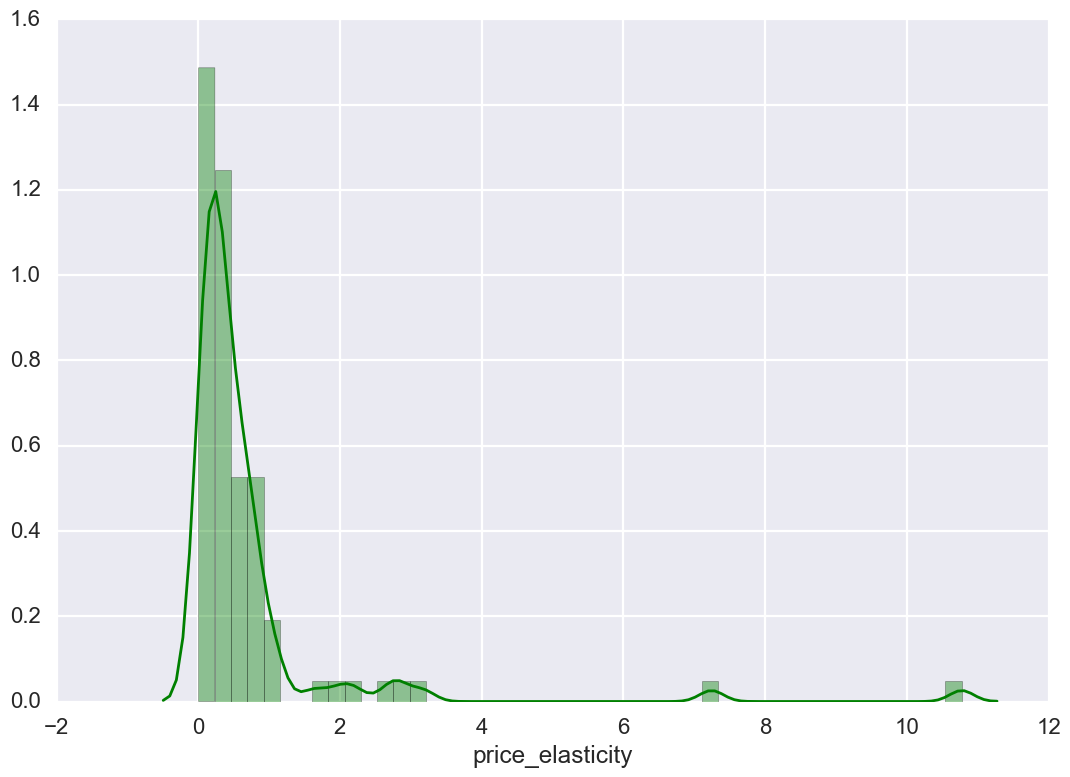

In [181]:
sns.distplot(
    a = abs(df[df['course_partner']=='Microsoft']['price_elasticity']),
    norm_hist = False,
    hist = True,
    color = 'g'
)


#### Non Microsoft

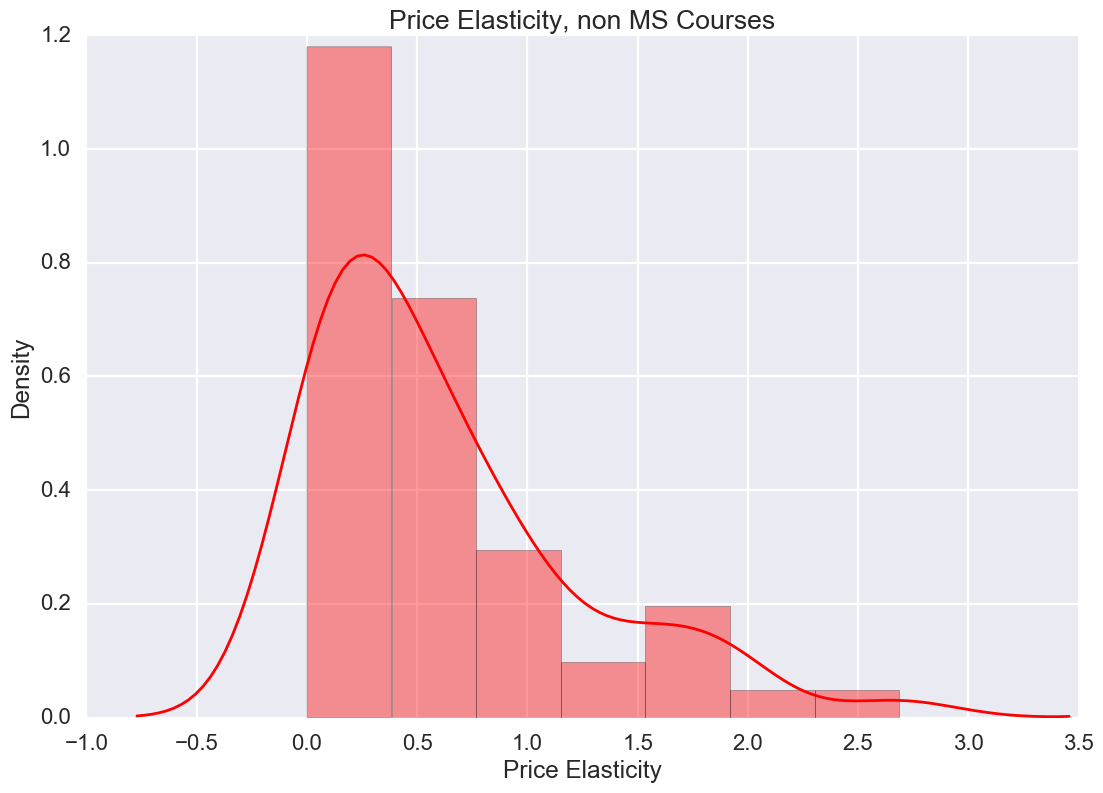

In [182]:
ax = sns.distplot(
    a = abs(df[df['course_partner']!='Microsoft']['price_elasticity']),
    norm_hist = False,
    hist = True,
    color = 'r',
)

ax.set(title = 'Price Elasticity, non MS Courses',
      xlabel = 'Price Elasticity',
      ylabel = 'Density')

## % Difference in Expected Value

### Expected Value = VTR * Seat Price
### % Difference Expected Value = (Expected_Value_High_Price - Expected_Value_Low_Price) * 100 /Expected_Value_Low_Price

#### Microsoft

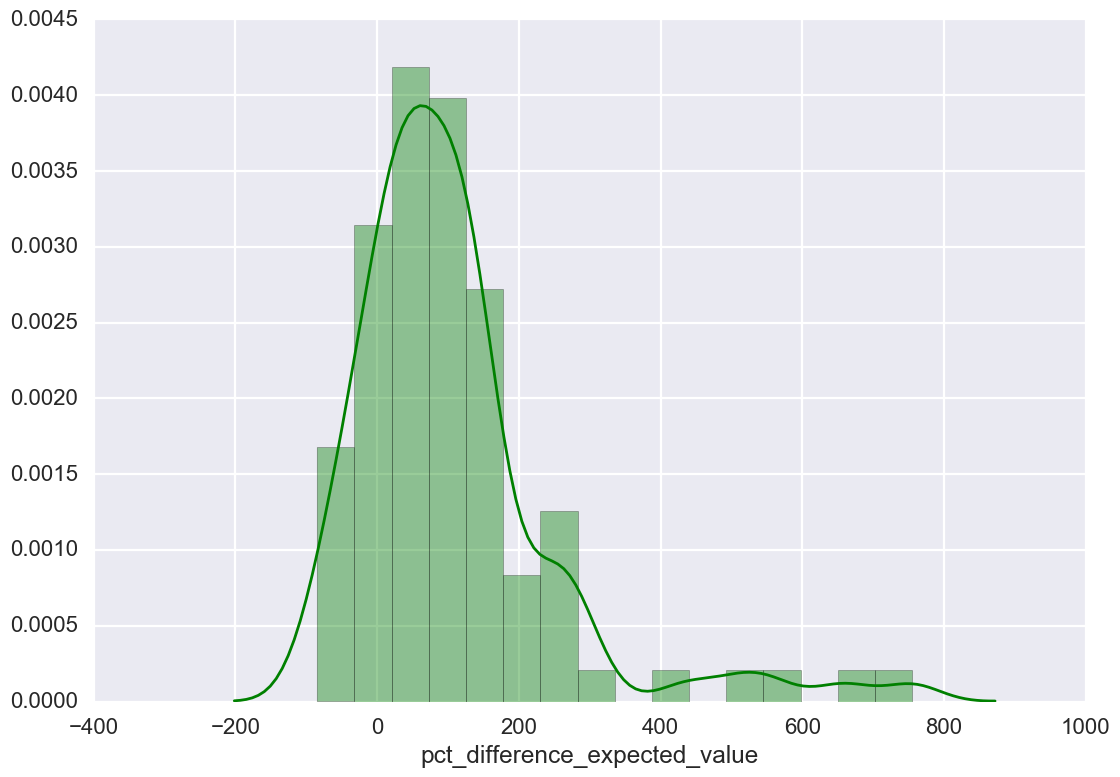

In [183]:
sns.distplot(
    a = (df[df['course_partner']=='Microsoft']['pct_difference_expected_value']),
    norm_hist = True,
    hist = True,
    color = 'g',

)

#### Non Microsoft

In [184]:
print ("mean: %s" % df[df['course_partner']!='Microsoft']['pct_difference_expected_value'].mean())
print ("median: %s" % df[df['course_partner']!='Microsoft']['pct_difference_expected_value'].quantile(0.5))

mean: 55.700335139537856
median: 35.9247814290021


## Looking within the MS Prof Cert

### First at difference in VTR

In [136]:
# sns.factorplot(
#     data = df,
#     x = 'ms_course_program_group',
#     y = 'pct_difference_vtr',
#     kind = 'bar',
#     order = ['Unit 1', 'Unit 2', 'Unit 3'],
#     size = 10
# )

The VTR degradation goes down the deeper into a program you go. Interesting! Less price sensitivity the more invested you are.

In [ ]:
# sns.factorplot(
#     data = df.groupby('ms_course_program_number').mean().reset_index(),
#     x = 'ms_course_program_number',
#     y = 'pct_difference_expected_value',
#     kind = 'bar',
#     order = ['1','2','3','5','6','7','8','9'],
#     size = 10
# )

### Now let's look at the expected value across the program

In [ ]:
# sns.factorplot(
#     data = df,
#     x = 'ms_course_program_group',
#     y = 'pct_difference_expected_value',
#     kind = 'bar',
#     order = ['Unit 1', 'Unit 2', 'Unit 3'],
#     size = 8
# )

In [ ]:
ax = sns.factorplot(
    data = df,
    x = 'ms_course_program_group',
    y = 'pct_difference_expected_value_actual_price',
    kind = 'box',
    order = ['Unit 1', 'Unit 2', 'Unit 3'],
    size = 8
)

ax.set(title = 'Pct Change in Expected Value \nby MS Program Unit',
      xlabel = 'Program Group',
      ylabel = 'Pct Difference in Expected Value (%)',
      ylim = (-50, 100))

Regardless of drop in VTR, the higher price point courses drive more value per learner than their lower priced counterparts.

The percent difference is greater the further you are in the program, driven by the VTR of Unit 3

# This suggests that we can, at the very least, increase price at the end of a program.

* * *

## Now let's try to find how much VTR varies as a function of price

In [138]:
df.columns

Index(['course_number', 'lower_course_id', 'higher_course_id', 'program_type',
       'program_title', 'price_increase_grouping', 'stem_non_stem',
       'ms_course_program_number', 'program_slot_number', 'pacing_type',
       'course_partner', 'course_subject', 'level_type',
       'lower_course_verification_end_date',
       'higher_course_verification_end_date', 'lower_course_price',
       'higher_course_price', 'price_difference', 'lower_course_enrolls',
       'lower_course_verifications', 'lower_course_bookings',
       'lower_course_vtr', 'higher_course_enrolls',
       'higher_course_verifications',
       'higher_course_verifications_minus_vouchers', 'higher_course_bookings',
       'higher_course_vtr', 'undiscounted_vtr', 'pct_difference_price',
       'pct_difference_vtr', 'pct_difference_undiscounted_vtr',
       'price_elasticity', 'expected_value_lower', 'expected_value_higher',
       'expected_value_higher_actual_price',
       'expected_value_higher_undiscounted', 'pc

In [139]:
# sns.distplot(df.price_difference)
# df['price_difference_group'] = pd.cut(df.price_difference, bins = [0,25, 50, 150])

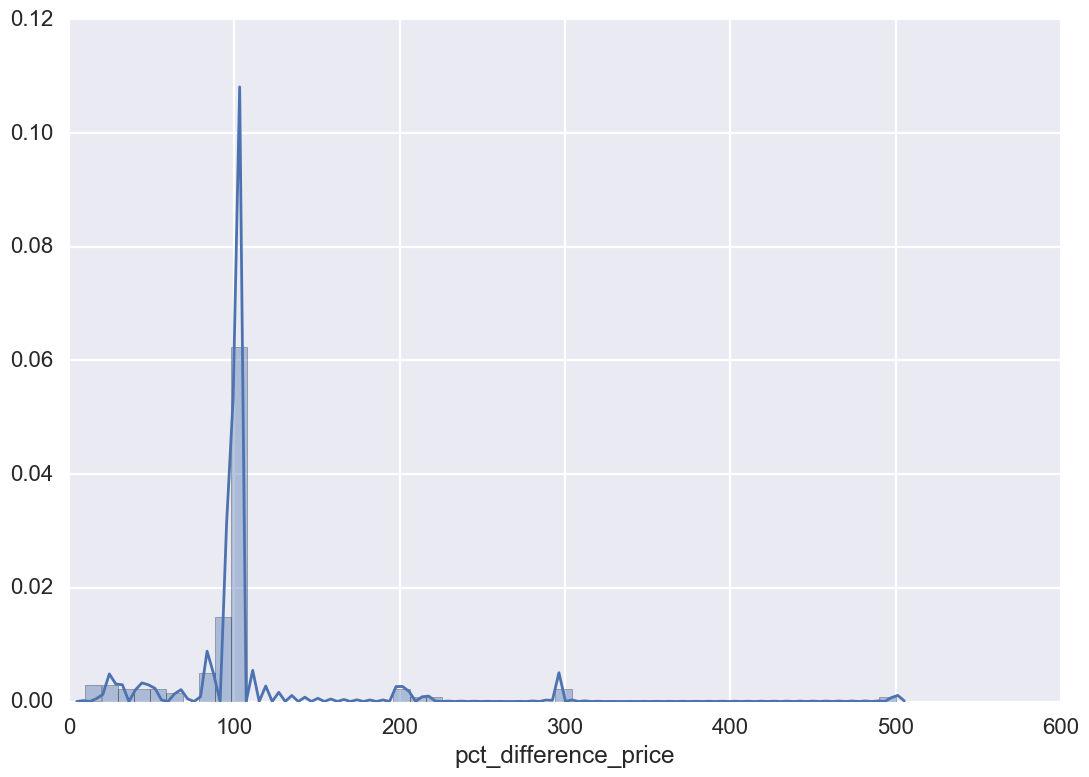

In [140]:
sns.distplot(df.pct_difference_price)

Slice our distribution up into bins:

- 0 to 50% change in price
- 50 to 100% change in price
- '> 100% change in price

In [141]:
df[df['course_partner']!='Microsoft'][['lower_course_price','higher_course_price','price_increase_grouping']]

,lower_course_price,higher_course_price,price_increase_grouping
0,50.0,100.0,49 to 99
1,49.0,100.0,49 to 99
2,25.0,49.0,25 to 50
3,25.0,49.0,25 to 50
4,49.0,99.0,49 to 99
5,49.0,99.0,49 to 99
6,25.0,50.0,25 to 50
7,25.0,50.0,25 to 50
8,50.0,99.0,49 to 99
9,30.0,50.0,25 to 50


In [150]:
df['pct_price_difference_group'] = pd.cut(df.pct_difference_price, bins = [0, 50, 105])

In [151]:
df[df['course_partner']!='Microsoft'].groupby('pct_price_difference_group').count()

,course_number,lower_course_id,higher_course_id,program_type,program_title,price_increase_grouping,stem_non_stem,ms_course_program_number,program_slot_number,pacing_type,...,expected_value_higher,expected_value_higher_actual_price,expected_value_higher_undiscounted,pct_difference_expected_value,pct_difference_expected_value_actual_price,pct_difference_expected_value_undiscounted,is_worse,year,ms_course_program_group,pct_difference_vtr_fixed
pct_price_difference_group,,,,,,,,,,,,,,,,,,,,,
"(0, 50]",13,13,13,6,6,13,13,0,6,13,...,13,0,13,13,0,13,13,13,0,13
"(50, 105]",34,34,34,11,11,34,34,0,11,34,...,34,0,34,34,0,34,34,34,0,34


In [161]:
df[df['course_partner']!='Microsoft'].groupby(['price_increase_grouping','stem_non_stem']).count()

course_number  lower_course_id  \
price_increase_grouping stem_non_stem                                   
25 to 50                STEM                      18               18   
                        non-STEM                   6                6   
49 to 99                STEM                       7                7   
                        non-STEM                   4                4   
other                   STEM                       3                3   
                        non-STEM                  15               15   

                                       higher_course_id  program_type  \
price_increase_grouping stem_non_stem                                   
25 to 50                STEM                         18             3   
                        non-STEM                      6             2   
49 to 99                STEM                          7             6   
                        non-STEM                      4             0   
other                   STEM                          3             3   
                        non-STEM                     15             8   

                                       program_title  \
price_increase_grouping stem_non_stem                  
25 to 50                STEM                       3   
                        non-STEM                   2   
49 to 99                STEM                       6   
                        non-STEM                   0   
other                   STEM                       3   
                        non-STEM                   8   

                                       ms_course_program_number  \
price_increase_grouping stem_non_stem                             
25 to 50                STEM                                  0   
                        non-STEM                              0   
49 to 99                STEM                                  0   
                        non-STEM                              0   
other                   STEM                                  0   
                        non-STEM                              0   

                                       program_slot_number  pacing_type  \
price_increase_grouping stem_non_stem                                     
25 to 50                STEM                             3           18   
                        non-STEM                         2            6   
49 to 99                STEM                             6            7   
                        non-STEM                         0            4   
other                   STEM                             3            3   
                        non-STEM                         8           15   

                                       course_partner  course_subject  \
price_increase_grouping stem_non_stem                                   
25 to 50                STEM                       18              18   
                        non-STEM                    6               6   
49 to 99                STEM                        7               7   
                        non-STEM                    4               4   
other                   STEM                        3               3   
                        non-STEM                   15              15   

                                                 ...             \
price_increase_grouping stem_non_stem            ...              
25 to 50                STEM                     ...              
                        non-STEM                 ...              
49 to 99                STEM                     ...              
                        non-STEM                 ...              
other                   STEM                     ...              
                        non-STEM                 ...              

                                       expected_value_higher_actual_price  \
price_increase_grouping stem_non_stem                                       
25 to 

In [157]:
df['pct_difference_vtr_fixed'] = np.where(df['pct_difference_vtr']>0, 0, df['pct_difference_vtr'])
df['pct_difference_vtr_fixed'] = df['pct_difference_vtr_fixed'].astype('float64')

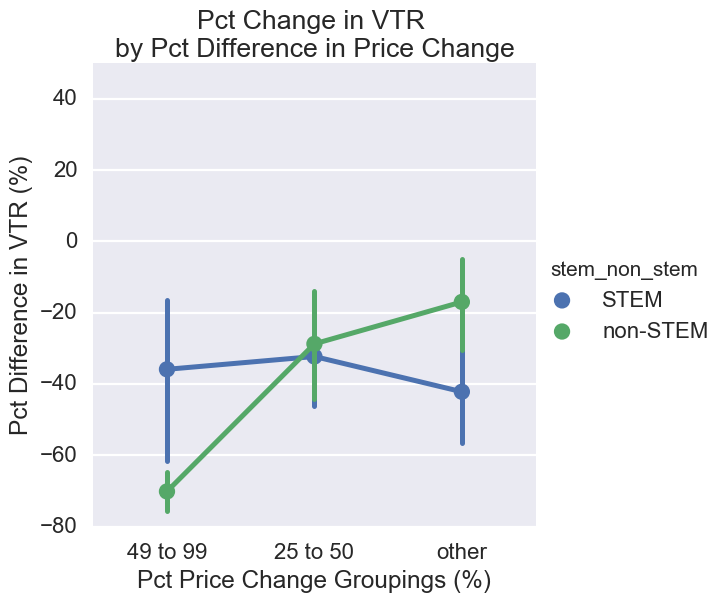

In [166]:
ax = sns.factorplot(data = df[df['course_partner']!='Microsoft'], 
               x = 'price_increase_grouping', 
               y = 'pct_difference_vtr_fixed', 
               size = 6,
                   hue = 'stem_non_stem')
ax.set(title = 'Pct Change in VTR \nby Pct Difference in Price Change',
      xlabel = 'Pct Price Change Groupings (%)',
      ylabel = 'Pct Difference in VTR (%)',
      ylim = (-80, 50))

In [173]:
df[df['course_partner']!='Microsoft'].groupby(['price_increase_grouping',
                                               'stem_non_stem']).quantile(0.3)['pct_difference_vtr_fixed']

price_increase_grouping  stem_non_stem
25 to 50                 STEM            -48.351684
                         non-STEM        -37.306727
49 to 99                 STEM            -49.713885
                         non-STEM        -75.042321
other                    STEM            -50.763601
                         non-STEM        -13.586996
Name: pct_difference_vtr_fixed, dtype: float64

In [163]:
# ax = sns.factorplot(data = df, 
#                x = 'pct_price_difference_group', 
#                y = 'pct_difference_vtr', 
#                size = 6,)
# ax.set(title = 'Pct Change in VTR \nby Pct Difference in Price Change',
#       xlabel = 'Pct Price Change Groupings (%)',
#       ylabel = 'Pct Difference in VTR (%)',
#       ylim = (-80, 50))

% change in VTR trends based on the size of the price change.

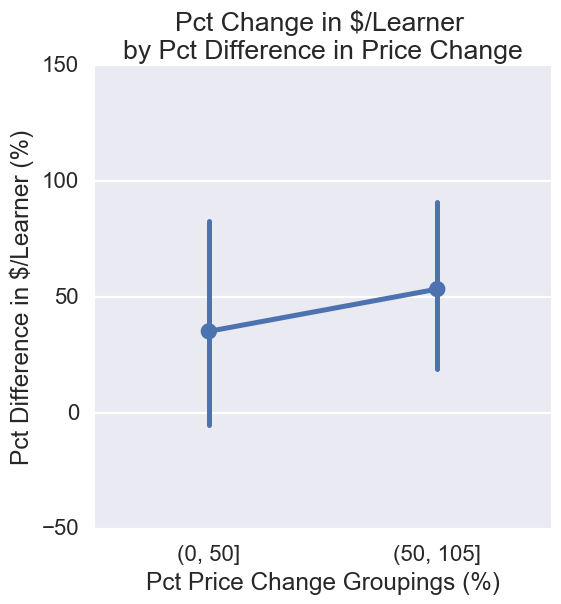

In [52]:
ax = sns.factorplot(data = df[df['course_partner']!='Microsoft'],
               x = 'pct_price_difference_group',
               y = 'pct_difference_expected_value', 
               size = 6)
ax.set(title = 'Pct Change in $/Learner \nby Pct Difference in Price Change',
      xlabel = 'Pct Price Change Groupings (%)',
      ylabel = 'Pct Difference in $/Learner (%)',
      ylim = (-50, 150))

% change in value is optimized between 50-100% change in price. This trend isn't consistent across price points, so not sure how much we should latch onto it.

## Switching directions a bit, let's look at the likelihood of verifying in the second course of a program given that you've verified in the first

In [205]:
second_course_verification_query = """

SELECT
	a.program_type,
	a.program_title,
	course_price,
	SUM(CASE WHEN first_course_verified = 1 THEN cnt_users ELSE 0 END) * 100.0/SUM(cnt_users) AS first_course_vtr,
	SUM(cnt_users) AS cnt_first_course_users_verify,
	SUM(CASE WHEN first_course_verified = 1 AND second_course_verified = 1 THEN cnt_users ELSE 0 END) * 100.0/SUM(CASE WHEN first_course_verified = 1 THEN cnt_users ELSE 0 END) AS second_course_vtr,
	SUM(CASE WHEN first_course_verified = 1 AND second_course_verified = 1 THEN cnt_users ELSE 0 END) AS cnt_second_course_users_verify,
	SUM(CASE WHEN first_course_verified = 1 AND second_course_verified = 1 AND third_course_verified = 1 THEN cnt_users ELSE 0 END) * 100.0/
	SUM(CASE WHEN first_course_verified = 1 AND second_course_verified = 1 THEN cnt_users ELSE 0 END) AS third_course_vtr_after_first_second_course_verify,
	SUM(CASE WHEN first_course_verified = 1 AND second_course_verified = 1 AND third_course_verified = 1 THEN cnt_users ELSE 0 END) AS cnt_third_course_users_verify
FROM 
	ahemphill.program_verify a 
join
(
select 
program_type, program_title, max(course_seat_price) AS course_price, avg(course_seat_price)
from production.d_program_course a 
join business_intelligence.course_master b
on a.course_id = b.course_id
and b.course_start_date >= '2017-01-01'
and program_slot_number = 1
and program_type = 'MicroMasters'
group by 1,2

) b
on a.program_type = b.program_type
and a.program_title = b.program_title
GROUP BY 
	1,2,3
    
"""

In [216]:
connection = vertica_python.connect(**conn_info)

cur = connection.cursor('dict')

cur.execute(second_course_verification_query)
extract = cur.fetchall()
verification_df = pd.DataFrame(extract)

connection.close()

In [217]:
verification_df['second_course_vtr'] = verification_df.second_course_vtr.astype(float)

In [220]:
test = verification_df.unstack().reset_index()
test = test[test['level_0'].isin(['first_course_vtr', 'second_course_vtr'])]

In [221]:
test['vtr'] = test[0].astype(float)

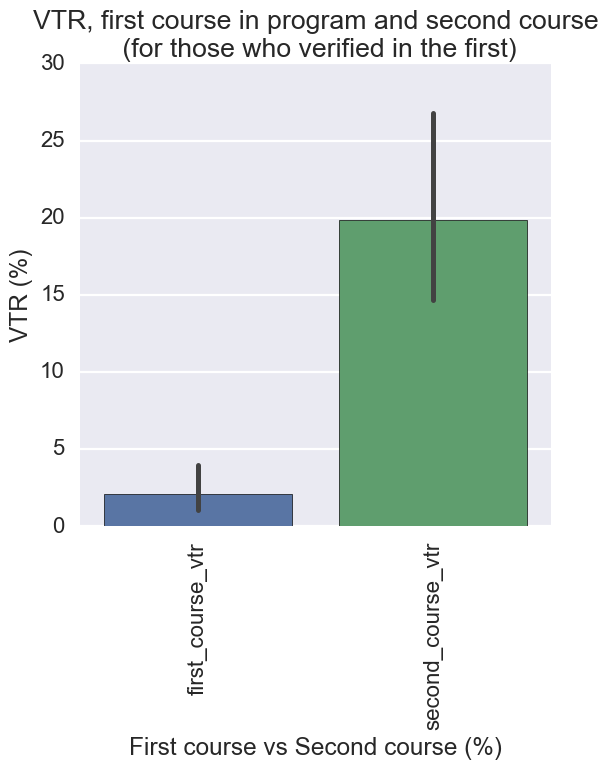

In [247]:
ax = sns.factorplot(
    data = test[test['level_0'].isin(['first_course_vtr', 'second_course_vtr'])],
    y = 'vtr',
    x = 'level_0',
    kind = 'bar',
    size = 6
)
ax.set_xticklabels(rotation=90)
ax.set(title = 'VTR, first course in program and second course\n (for those who verified in the first)',
      xlabel = 'First course vs Second course (%)',
      ylabel = 'VTR (%)')

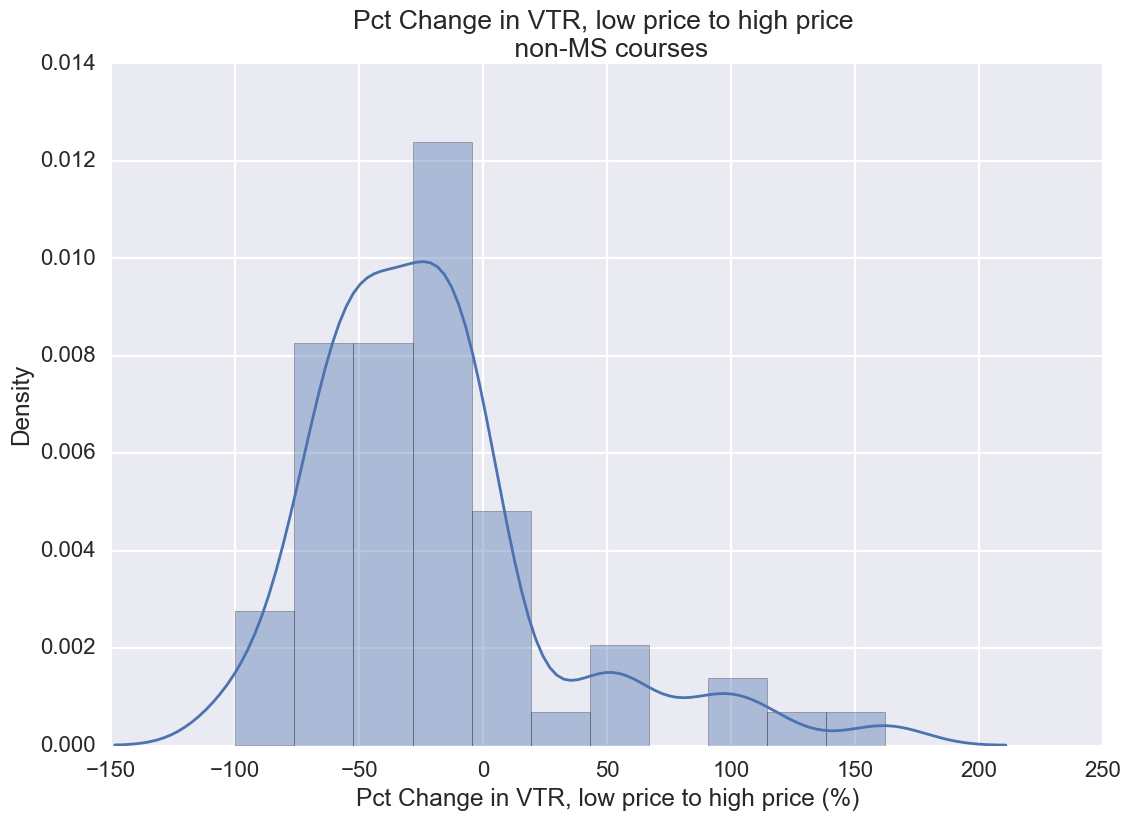

In [253]:
ax = sns.distplot(df[df['course_partner']!='Microsoft'].pct_difference_vtr)

ax.set(title = 'Pct Change in VTR, low price to high price \n non-MS courses',
      xlabel = 'Pct Change in VTR, low price to high price (%)',
      ylabel = 'Density')

In [254]:
print ("mean: %s" % df[df['course_partner']!='Microsoft']['pct_difference_vtr'].mean())
print ("median: %s" % df[df['course_partner']!='Microsoft']['pct_difference_vtr'].quantile(0.5))

mean: -20.69632587789304
median: -23.146832445233866


In [ ]:
ax = sns.factorplot(
    data = df,
    x = 'ms_course_program_group',
    y = 'pct_difference_undiscounted_vtr',
    kind = 'box',
    order = ['Unit 1', 'Unit 2', 'Unit 3'],
    size = 8,
    orient = 'v'
)

# ax.set(title = 'Pct Change in VTR \nby MS Program Unit',
#       xlabel = 'Program Group',
#       ylabel = 'Pct Difference in VTR (%)')